In [1]:
import pytest
import torch
from torch import einsum, nn
import triton
import triton.language as tl
from triton_testing.multihead_attention import multihead_flash_attention
from triton_testing.multiquery_attention import multiquery_flash_attention
from triton_testing.query_norm import fused_query_norm, naive_query_norm
from triton_testing.fused_multiquery_querynorm import multiquery_querynorm_flash_attention

## Multiquery Attention

The following blocks compare a triton implementation of multiquery attention with a baseline flashattention implementation (keys and values are repeated on all heads to get equivalent outputs from flashattention). The forward passes of both implementations are quite similar but the backward pass of multiquery attention requires a reduction over the gradients of k and v

In [2]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['multiquery_flash_attention','multihead_flash_attention'],
    line_names=['Triton MultiQuery Attention','Multihead FlashAttention'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'multiquery-attention-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd','bwd']]


@triton.testing.perf_report(configs)
def bench_flash_multiquery_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    if provider == "multiquery_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        fn = lambda: multiquery_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms, min_ms, max_ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms, min_ms, max_ms
    if provider == "multihead_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = k.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        v = v.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        fn = lambda: multihead_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms, min_ms, max_ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
        return ms, min_ms, max_ms

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


multiquery-attention-fwd:
     N_CTX  Triton MultiQuery Attention  Multihead FlashAttention
0   1024.0                     0.196004                  0.183648
1   2048.0                     0.532978                  0.551493
2   4096.0                     1.856551                  1.886937
3   8192.0                     6.932261                  6.977683
4  16384.0                    26.761900                 26.817877
5  32768.0                   105.197571                105.312256
multiquery-attention-bwd:
     N_CTX  Triton MultiQuery Attention  Multihead FlashAttention
0   1024.0                     1.293326                  0.604255
1   2048.0                     2.871778                  1.892332
2   4096.0                     7.458264                  6.446967
3   8192.0                    23.675903                 23.496960
4  16384.0                    87.436287                 90.199043
5  32768.0                   334.340088                357.366791


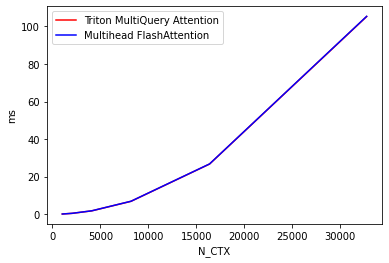

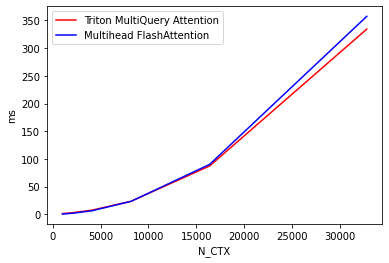

In [3]:
bench_flash_multiquery_attention.run(save_path='.', print_data=True)

## QueryNorm

QueryNorm is a custom norm operation similar to LN but with weights and bias scalars per head instead of per d_head element. This is to be applied to the queries of a multihead/query attention block. The following blocks compare the a triton implementation of this norm with a standard pytorch implementation

In [4]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
configs = [triton.testing.Benchmark(
    x_names=['D_HEAD'],
    x_vals=[512 * i for i in range(2, 16)],
    line_arg='provider',
    line_vals=['triton', 'torch'],
    line_names=['Triton QueryNorm', 'Torch QueryNorm'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name=f'query-norm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'N_CTX': N_CTX, 'dtype': torch.float16, 'mode': mode}
) for mode in ['forward', 'backward']]

@triton.testing.perf_report(configs)
def bench_query_norm(BATCH, H, N_CTX, D_HEAD, dtype, provider, mode='forward', eps=1e-5, device='cuda'):
    # create data
    q_shape = (BATCH, H, N_CTX, D_HEAD)
    w_shape = (1,H,1,1)
    w = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    q = torch.randn(q_shape, dtype=dtype, device='cuda')
    q.requires_grad_(True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-5
    # utility functions
    if provider == 'triton':
        y_fwd = lambda: fused_query_norm(q, w.flatten(), b.flatten(), eps)
    if provider == 'torch':
        y_fwd = lambda: naive_query_norm(q, w, b, eps)
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * q.numel() * q.element_size() / ms * 1e-6
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, rep=500)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * q.numel() * q.element_size() / ms * 1e-6
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True),
                                                     grad_to_none=[q], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

query-norm-forward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1377.289009       185.479239
1   1536.0       1370.090626       187.752344
2   2048.0       1389.455824       188.378234
3   2560.0       1382.130048       188.919000
4   3072.0       1378.898898       189.699768
5   3584.0       1380.397157       190.051230
6   4096.0       1379.705324       187.827085
7   4608.0       1393.833788       190.768374
8   5120.0       1388.474620       191.141364
9   5632.0       1382.792808       186.728369
10  6144.0       1382.535049       190.773512
11  6656.0       1383.064946       187.492952
12  7168.0       1381.436441       191.073685
13  7680.0       1332.634380       191.042296
query-norm-backward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1172.612353        99.784130
1   1536.0       1119.918959       100.378493
2   2048.0       1260.307658       100.760029
3   2560.0       1232.909672       100.704113
4   3072.0       1286.888734       101.

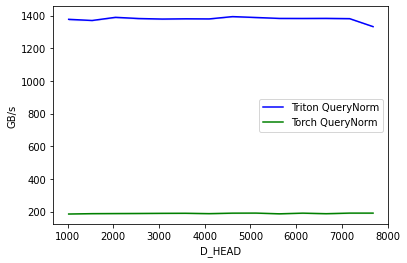

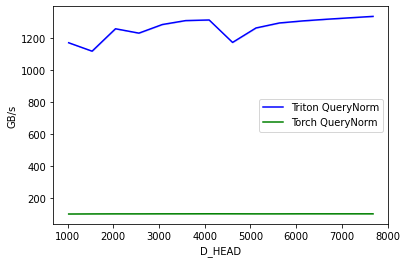

In [5]:
bench_query_norm.run(save_path='.', print_data=True)

## Fusing Multiquery Attention With QueryNorm

We can also fuse multiquery attention with query norm to avoid launching two seperate kernels. The following block compares a fused multiquery attention + QueryNorm kernel with a baseline of composing the two triton kernels we saw previously

In [6]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['fused_multiquery_querynorm','unfused_multiquery_querynorm'],
    line_names=['Fused Multiquery QueryNorm','Unfused Multiquery QueryNorm'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'fused_multiquery_querynorm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd']]


@triton.testing.perf_report(configs)
def bench_multiquery_querynorm_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    eps = 1e-6
    if provider == "fused_multiquery_querynorm":
        fn = lambda: multiquery_querynorm_flash_attention(q, k, v, w, b, eps)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms, min_ms, max_ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
        return ms, min_ms, max_ms
    if provider == "unfused_multiquery_querynorm":
        fn = lambda: multiquery_flash_attention(fused_query_norm(q, w, b, eps),k,v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms, min_ms, max_ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
        return ms, min_ms, max_ms

fused_multiquery_querynorm-fwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    0.182150                      0.246641
1   2048.0                    0.546648                      0.683392
2   4096.0                    1.883156                      2.153539
3   8192.0                    6.984631                      7.519232
4  16384.0                   26.975233                     28.203348
5  32768.0                  107.105278                    108.843010
fused_multiquery_querynorm-bwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    1.488070                      1.484256
1   2048.0                    3.247775                      3.236045
2   4096.0                    8.184747                      8.118699
3   8192.0                   25.434454                     25.342978
4  16384.0                   91.746307                     91.511810
5  32768.0                  347.025421 

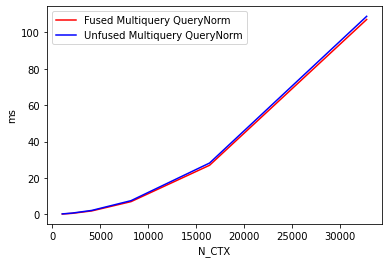

In [ ]:
bench_multiquery_querynorm_attention.run(save_path='.', print_data=True)